API FOR Dataset

In [ ]:
import kagglehub
path = kagglehub.dataset_download("noobyogi0100/shoe-dataset")

print("Path to dataset files:", path)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print ('modules loaded')

modules loaded


### Define a function to show example training images

In [2]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25: 
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [3]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):    
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)
    

### Define  a function to print text in RGB foreground and background colors

In [4]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):

    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) 
    return

In [5]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience 
        self.stop_patience=stop_patience
        self.threshold=threshold 
        self.factor=factor 
        self.dwell=dwell
        self.batches=batches 
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch
        

        self.count=0 
        self.stop_count=0        
        self.best_epoch=1  
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr))      
        self.highest_tracc=0.0 
        self.lowest_vloss=np.inf 
        self.best_weights=self.model.get_weights() 
        self.initial_weights=self.model.get_weights()   
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting training with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) 
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') 
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        current_lr=lr
        v_loss=logs.get('val_loss') 
        acc=logs.get('accuracy')  
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold:
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: 
                self.highest_tracc=acc 
                self.best_weights=self.model.get_weights() 
                self.count=0
                self.stop_count=0 
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1               
            else: 
                if self.count>=self.patience -1: 
                    color=(245, 170, 66)
                    lr= lr* self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count=0 
                    self.stop_count=self.stop_count + 1
                    self.count=0 
                    if self.dwell:
                        self.model.set_weights(self.best_weights) 
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 
        else: 
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: 
                self.lowest_vloss=v_loss                
                self.best_weights=self.model.get_weights()
                self.count=0
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1
            else:
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    lr=lr * self.factor 
                    self.stop_count=self.stop_count + 1 
                    self.count=0 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    if self.dwell:
                        self.model.set_weights(self.best_weights) 
                else: 
                    self.count =self.count +1 
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1:
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True 
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt training ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True 
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

### Define a function to plot the training data

In [6]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


### define a function to create confusion matrix and classification report

In [7]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             
    classes=list(new_dict.values())     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value) 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### define a function to save the model and the associated class_dict.csv file

In [8]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc

### define a function that uses the trained model and the
### class_dict.csv file to predict images

In [9]:
def predictor(sdir, csv_path, model_path, averaged=True, verbose=True):    
    class_df = pd.read_csv(csv_path)    
    class_count = len(class_df['class'].unique())
    img_height = int(class_df['height'].iloc[0])
    img_width = int(class_df['width'].iloc[0])
    img_size = (img_width, img_height)    
    scale = class_df['scale by'].iloc[0] 
    image_list = []
    
    try: 
        s = int(scale)
        s2 = 1
        s1 = 0
    except:
        split = scale.split('-')
        s1 = float(split[1])
        s2 = float(split[0].split('*')[1])
        
    path_list = []
    paths = os.listdir(sdir)    
    for f in paths:
        path_list.append(os.path.join(sdir, f))
    
    if verbose:
        print('Model is being loaded - this will take about 10 seconds')
        
    model = load_model(model_path)
    image_count = len(path_list) 
    image_list = []
    file_list = []
    good_image_count = 0
    
    for i in range(image_count):        
        try:
            img = cv2.imread(path_list[i])
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            good_image_count += 1
            img = img * s2 - s1             
            image_list.append(img)
            file_name = os.path.split(path_list[i])[1]
            file_list.append(file_name)
        except:
            if verbose:
                print(path_list[i], 'is an invalid image file')
                
    if good_image_count == 1:
        averaged = True
        
    image_array = np.array(image_list)    
    preds = model.predict(image_array)    
    
    if averaged:
        psum = [0] * class_count
        
        for p in preds:
            for i in range(class_count):
                psum[i] += p[i]
                
        index = np.argmax(psum)
        klass = class_df['class'].iloc[index]
        prob = psum[index] / good_image_count
        
        for img in image_array:
            test_img = np.expand_dims(img, axis=0)
            test_index = np.argmax(model.predict(test_img))
            if test_index == index:
                if verbose:
                    plt.axis('off')
                    plt.imshow(img)
                    print(f'predicted species is {klass} with a probability of {prob:6.4f}')
                break
        return klass, prob, img, None
    else:
        pred_class = []
        prob_list = []
        
        for i, p in enumerate(preds):
            index = np.argmax(p)
            klass = class_df['class'].iloc[index]
            image_file = file_list[i]
            pred_class.append(klass)
            prob_list.append(p[index])
            
        Fseries = pd.Series(file_list, name='image file')
        Lseries = pd.Series(pred_class, name='species')
        Pseries = pd.Series(prob_list, name='probability')
        df = pd.concat([Fseries, Lseries, Pseries], axis=1)
        
        if verbose:
            length = len(df)
            print(df.head(length))
            
        return None, None, None, df

### define a function tha takes in a dataframe df, and integer max_size and a string column
### and returns a dataframe where the number of samples for any class specified by column
### is limited to max samples

In [10]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df['labels'].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group['labels']
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df['labels'].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

### define a function that takes in a dataframe, and integers max_samples, min_samples. 
it uses the function trim to set the maximum number of samples in a class defined by the string column to max_samples.
if the number of samples is less than min_samples the class is eliminated from the dataset. If some classes have
less than max_samples, then augmented images are created for that class  and stored in the working_dir so the class
will have max_samples of images.  After augmentation an aug_df is created for the augmented images in the
working_dir. The aug_df is then merged with the original train_df to produce a new train_df that has exactly
max_sample images in each class thus creating a balanced training set.

In [11]:
def balance(train_df, max_samples, min_samples, column, working_dir, image_size):
    train_df = train_df.copy()
    train_df = trim(train_df, max_samples, min_samples, column)
    
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    
    for label in train_df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)
    
    total = 0
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=.2,
                             height_shift_range=.2, zoom_range=.2)
    
    groups = train_df.groupby('labels')
    
    for label in train_df['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        
        if sample_count < max_samples:
            aug_img_count = 0
            delta = max_samples - sample_count
            target_dir = os.path.join(aug_dir, label)
            
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=image_size,
                                              class_mode=None, batch_size=1, shuffle=False, 
                                              save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count
    
    print('Total Augmented images created=', total)
    
    if total > 0:
        aug_fpaths = []
        aug_labels = []
        classlist = os.listdir(aug_dir)
        
        for klass in classlist:
            classpath = os.path.join(aug_dir, klass)
            flist = os.listdir(classpath)
            
            for f in flist:
                fpath = os.path.join(classpath, f)
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        
        Fseries = pd.Series(aug_fpaths, name='filepaths')
        Lseries = pd.Series(aug_labels, name='labels')
        aug_df = pd.concat([Fseries, Lseries], axis=1)
        train_df = pd.concat([train_df, aug_df], axis=0).reset_index(drop=True)
    
    print(list(train_df['labels'].value_counts()))
    return train_df

### input an image of a boot to determine image shape

(239, 400, 3)


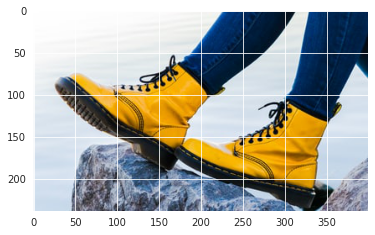

In [12]:
img_path=r'../input/shoe-dataset/shoeTypeClassifierDataset/training/boots/image1.jpg'
img=plt.imread(img_path)
print (img.shape)
imshow(img)


### define function to preprocess the dataframe
The function searches the image directories and creates a train_df, test_df and valid_df
It also checks to ensure each dataframehas the same number of classes

In [13]:
def preprocess (sdir, trsplit,random_seed):
    categories=['training', 'validation']
    for category in categories:
        catpath=os.path.join(sdir, category)
        filepaths=[]
        labels=[]    
        classlist=os.listdir(catpath)
        for klass in classlist:
            classpath=os.path.join(catpath,klass)
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        if category == 'training':
            df=pd.concat([Fseries, Lseries], axis=1)        
        else:
            valid_df=pd.concat([Fseries, Lseries], axis=1) 
    strat=df['labels']
    train_df, test_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=random_seed, stratify=strat)    
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
     # check that each dataframe has the same number of classes to prevent model.fit errors
    trcount=len(train_df['labels'].unique())
    tecount=len(test_df['labels'].unique())
    vcount=len(valid_df['labels'].unique())
    if trcount < tecount :         
        msg='** WARNING ** number of classes in training set is less than the number of classes in test set'
        print_in_color(msg, (255,0,0), (55,65,80))
        msg='This will throw an error in either model.evaluate or model.predict'
        print_in_color(msg, (255,0,0), (55,65,80))
    if trcount != vcount:
        msg='** WARNING ** number of classes in training set not equal to number of classes in validation set' 
        print_in_color(msg, (255,0,0), (55,65,80))
        msg=' this will throw an error in model.fit'
        print_in_color(msg, (255,0,0), (55,65,80))
        print ('train df class count: ', trcount, 'test df class count: ', tecount, ' valid df class count: ', vcount) 
        ans=input('Enter C to continue execution or H to halt execution')
        if ans =='H' or ans == 'h':
            print_in_color('Halting Execution', (255,0,0), (55,65,80))
            import sys
            sys.exit('program halted by user')            
    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df
    

In [14]:
sdir=r'../input/shoe-dataset/shoeTypeClassifierDataset'
random_seed =123
trsplit=.9
train_df, test_df, valid_df= preprocess(sdir, trsplit,random_seed)

train_df length:  1344   test_df length:  150   valid_df length:  300
[224, 224, 224, 224, 224, 224]


### create train, test and validation generators

In [15]:
working_dir = r'./'
img_size=(200, 400)
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  75   test steps:  2
Found 1343 validated image filenames belonging to 6 classes.
Found 150 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


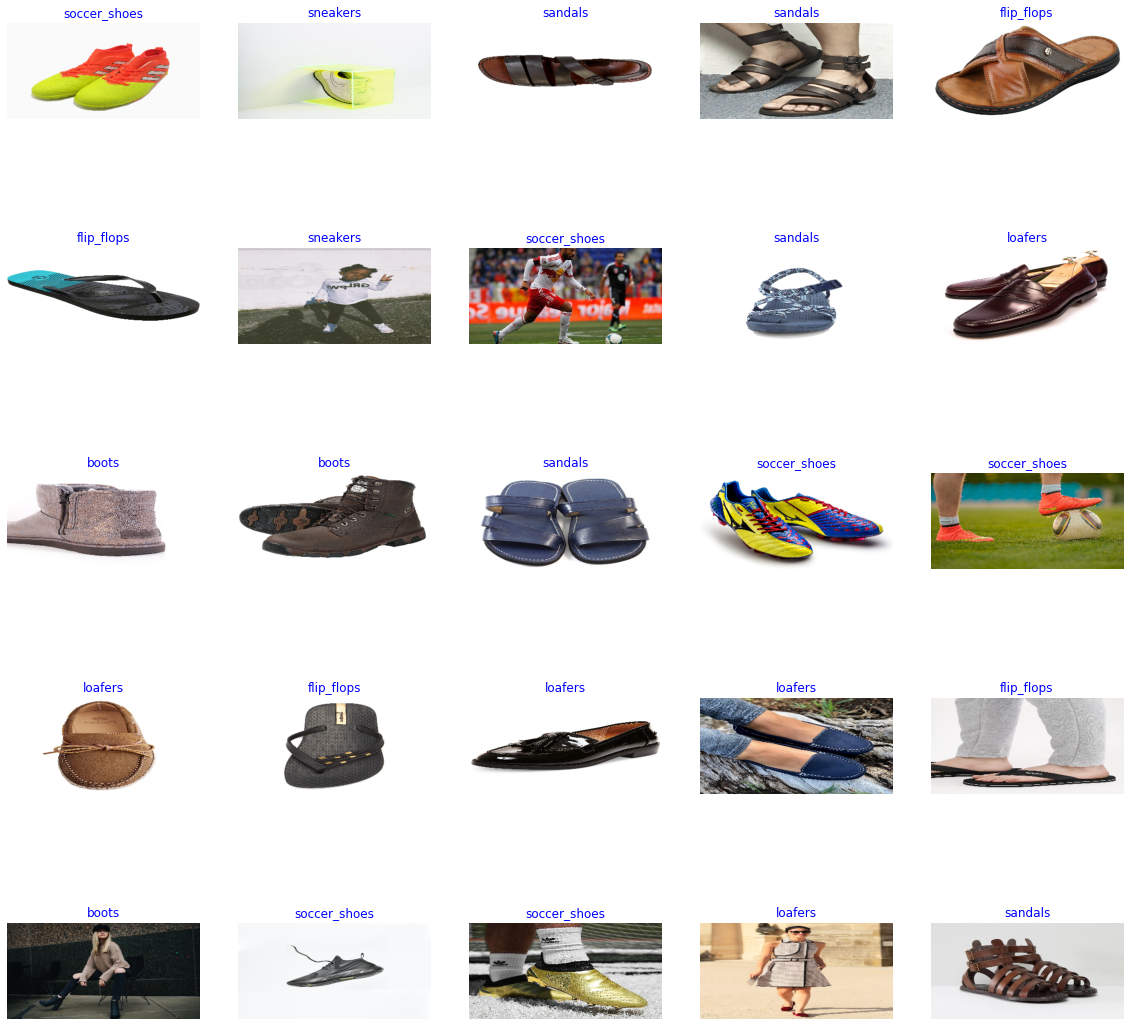

In [16]:
show_image_samples(train_gen)

### create the model

In [17]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

43941888/43941136 [==============================] - 2s 0us/step


### instantiate the custom callback and train the model

In [18]:
epochs = 40
patience = 1
stop_patience = 3
threshold = .9
factor = .5
dwell = True
freeze = False
ask_epoch = 5
batches = train_steps

callbacks = [LRA(model=model, base_model=base_model, patience=patience, stop_patience=stop_patience, 
                 threshold=threshold, factor=factor, dwell=dwell, batches=batches, initial_epoch=0, 
                 epochs=epochs, ask_epoch=ask_epoch)]

In [19]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting training with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     8.972   52.345   9.45049  65.333   0.00100  0.00100  accuracy     0.00    65.18  

 2 /40     7.381   78.779   7.78345  72.333   0.00100  0.00100  accuracy    50.50    35.67  

 3 /40     6.448   87.789   6.49676  80.333   0.00100  0.00100  accuracy    11.44    36.35  

 4 /40     5.698   94.937   5.76265  81.000   0.00100  0.00100  val_loss    11.30    35.52  

 5 /40     5.114   95.905   5.21086  81.333   0.00100  0.00100  val_loss     9.58    35.72  

enter H to halt training or an integer for number of epochs to run then ask again



 H


training has been halted at epoch 5 due to user input

Training is completed - model is set with weights from epoch 5 

training elapsed time was 0.0 hours,  3.0 minutes, 36.99 seconds)



### evaluate model on the test set then save the model

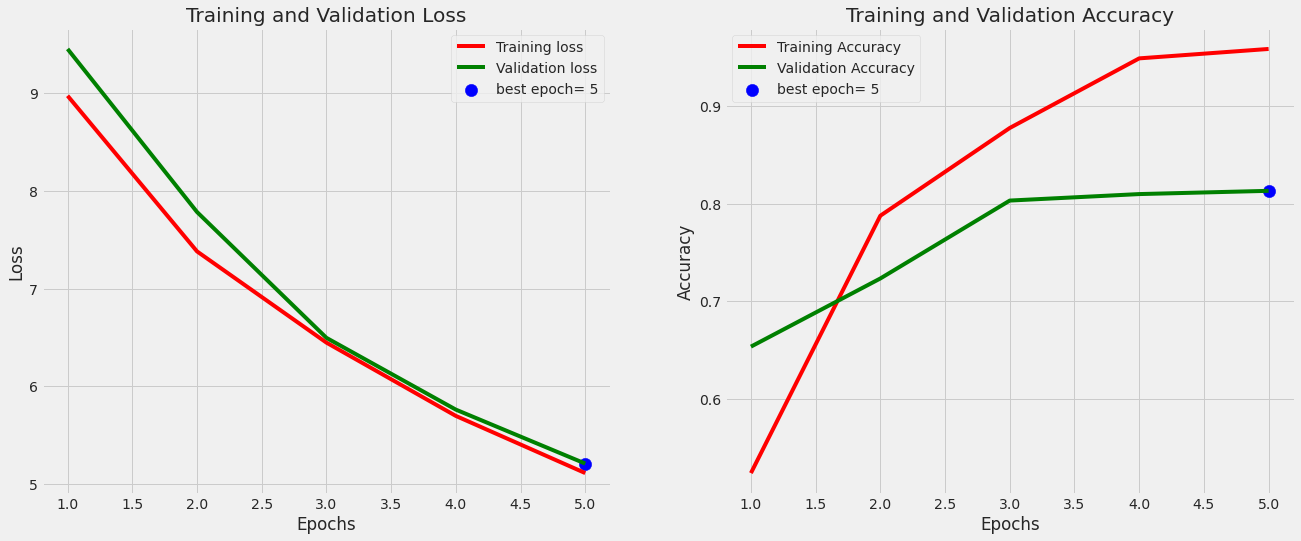

2/2 [==============================] - 4s 2s/step - loss: 5.3409 - accuracy: 0.7667
accuracy on the test set is 76.67 %

model was saved as ./EfficientNetB3-shoes-76.66.h5

class csv file was saved as ./class_dict.csv



In [20]:
tr_plot(history,0)
subject='shoes'
acc=model.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

### make predictions on test set and generate confusion matrix and classification report

2/2 [==============================] - 5s 2s/step


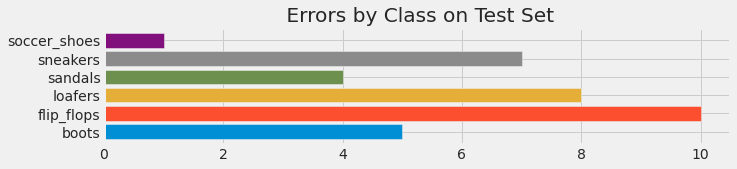

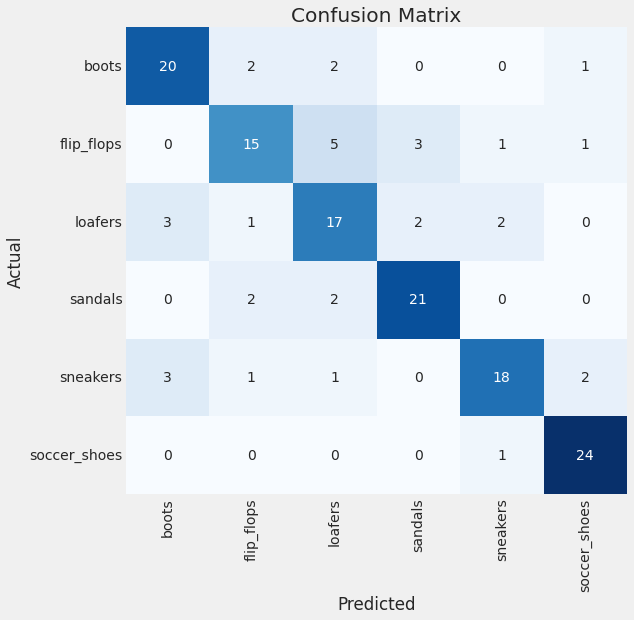

Classification Report:
----------------------
               precision    recall  f1-score   support

       boots       0.77      0.80      0.78        25
  flip_flops       0.71      0.60      0.65        25
     loafers       0.63      0.68      0.65        25
     sandals       0.81      0.84      0.82        25
    sneakers       0.82      0.72      0.77        25
soccer_shoes       0.86      0.96      0.91        25

    accuracy                           0.77       150
   macro avg       0.77      0.77      0.76       150
weighted avg       0.77      0.77      0.76       150



In [21]:
print_code=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject )  

### to test the classifier kernel create a directory with a single image of a boot in it

In [22]:
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
# input an image of letter A
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
# check if the directory was created and image stored
print (os.listdir(store_path))

['image1.jpg']


### use the predictor function to classify the single image

 image is of a boots with a probability of  84.15 %



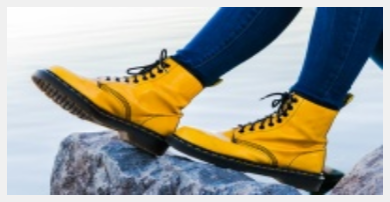

In [23]:
csv_path=csv_save_loc
model_path=model_save_loc 
klass, prob, img, df =predictor(store_path, csv_path,  model_path, averaged=True, verbose=False) 
msg=f' image is of a {klass} with a probability of {prob * 100: 6.2f} %'
plt.axis('off')
plt.imshow(img)
print_in_color(msg, (0,255,255), (65,85,55))